# Setup

**Imports**

In [1]:
import IPython

import ruptures as rpt
from scipy.signal import stft

import contextily as cx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Union, Tuple
import geopandas as gpd
from math import asin, cos, radians, sin, sqrt

from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from pygsp import graphs
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

rng = np.random.default_rng()

**Useful functions**

In [59]:
def fig_ax(scale=10) -> Tuple[plt.Figure, plt.Axes]:
    ratio = (1 + np.sqrt(5)) / 2
    fig, ax = plt.subplots(figsize=(scale, scale / ratio))
    fig.tight_layout(pad=2.5)
    ax.autoscale(enable=True, axis="x", tight=True)
    return fig, ax


def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r


def is_connected(graph) -> bool:
    return graph.is_connected()


def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def get_line_graph(n_nodes=10) -> graphs.Graph:
    """Return a line graph."""
    adjacency_matrix = np.eye(n_nodes)
    adjacency_matrix = np.c_[adjacency_matrix[:, -1], adjacency_matrix[:, :-1]]
    adjacency_matrix += adjacency_matrix.T
    line_graph = graphs.Graph(adjacency_matrix)
    line_graph.set_coordinates(kind="ring2D")
    line_graph.compute_laplacian("combinatorial")
    return line_graph

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences.

The signals have a varying number of symbols with a varying duration.
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [60]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [61]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


## An example

### Visualization

In [62]:
signal, labels = X_train[2], y_train[2]
output = stft(signal, FS)
frequencies, times, transform = output
transform = np.abs(transform)

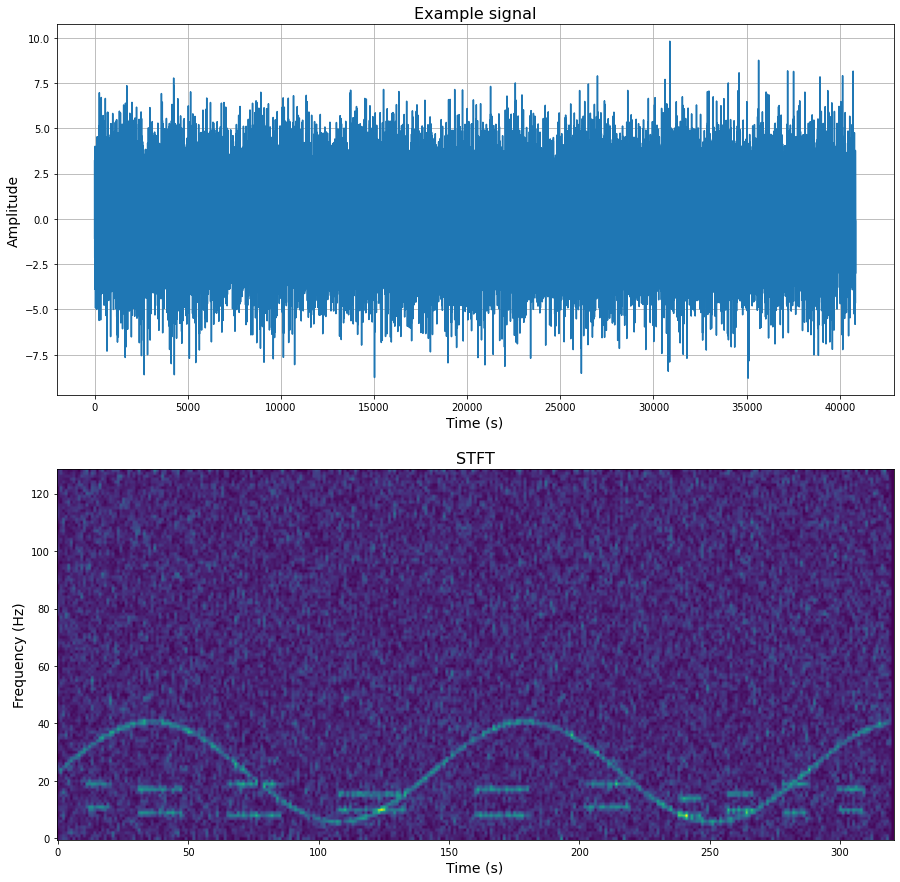

In [63]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(signal)
axs[0].set_title("Example signal", fontsize=16)
axs[0].set_xlabel("Time (s)", fontsize=14)
axs[0].set_ylabel("Amplitude", fontsize=14)
axs[0].grid()
axs[1].imshow(transform, aspect="auto", origin="lower")
axs[1].set_title("STFT", fontsize=16)
axs[1].set_xlabel("Time (s)", fontsize=14)
axs[1].set_ylabel("Frequency (Hz)", fontsize=14)
plt.show()

### Getting the optimal breakpoints given the number of breakpoints

We use dynamic programming to get the optimal breakpoints

In [64]:
number_of_breakpoints = len(labels) * 2

In [65]:
dynp_bkps = rpt.Dynp().fit_predict(transform.T, n_bkps=number_of_breakpoints)

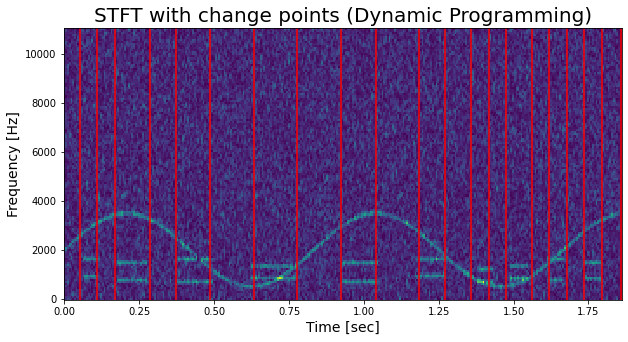

In [66]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, transform)
plt.ylabel("Frequency [Hz]", fontsize=14)
plt.xlabel("Time [sec]", fontsize=14)
for cp in dynp_bkps:
    plt.axvline(times[cp - 1], color="r")
plt.title("STFT with change points (Dynamic Programming)", fontsize=20)
plt.show()

### On this example only, we try to estimate the optimal penalty parameter $\beta$ of the PELT method

#### Function that computes the penalized cost

$$ V_{\beta}(\mathcal{T}, x) = \sum_{k=0}^K c(x[t_k : t_{k+1}]) + \beta K $$

In [67]:
def compute_cost(signal, breakpoints, penalty):
    breakpoints = [0] + breakpoints
    K = len(breakpoints)
    costs = np.zeros(K)
    cost = rpt.costs.cost_factory("l2")
    cost.fit(signal)
    for k in range(0, K - 1):
        costs[k] = cost.error(breakpoints[k], breakpoints[k + 1]) + penalty
    return np.sum(costs)

#### We compute the excess penalized risk [Truong et al. 2017]
$$ E(x, \beta) = V_{\beta}(\mathcal{T}_\star, x) - \min_{\mathcal{T}} V_{\beta}(\mathcal{T}, x) $$

In [68]:
costs = []
true_change_points = rpt.KernelCPD().fit_predict(transform.T, n_bkps=len(symbols) * 2)
for i, penalty in enumerate(np.linspace(0, 10, 100)):
    print(f"iteration {i + 1} / {100}", end="\r")
    change_points = rpt.Pelt().fit_predict(transform.T, pen=penalty)
    costs.append(
        compute_cost(transform.T, true_change_points, penalty)
        - compute_cost(transform.T, change_points, penalty)
    )

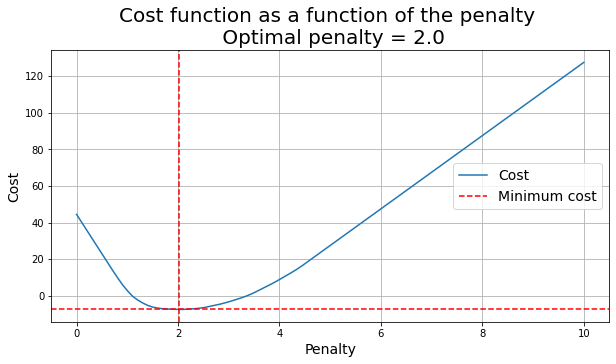

In [69]:
min_penalty_ind = np.argmin(costs)
penalty_list = np.linspace(0, 10, 100)
optimal_penalty = penalty_list[min_penalty_ind]

plt.figure(figsize=(10, 5))
plt.plot(penalty_list, costs, label="Cost")
plt.axvline(optimal_penalty, color="r", linestyle="--")
plt.axhline(np.min(costs), color="r", linestyle="--", label="Minimum cost")
plt.xlabel("Penalty", fontsize=14)
plt.ylabel("Cost", fontsize=14)
plt.title(
    "Cost function as a function of the penalty \n Optimal penalty = "
    + str(round(optimal_penalty, 1)),
    fontsize=20,
)
plt.legend(fontsize=14)
plt.grid()
plt.show()

Remark : Surprisingly, the minimum cost is negative. The source of error has not been found.

#### We visualize the output of the PELT method with the optimal penalty

In [70]:
pelt_bkps = rpt.Pelt().fit_predict(transform.T, pen=optimal_penalty)

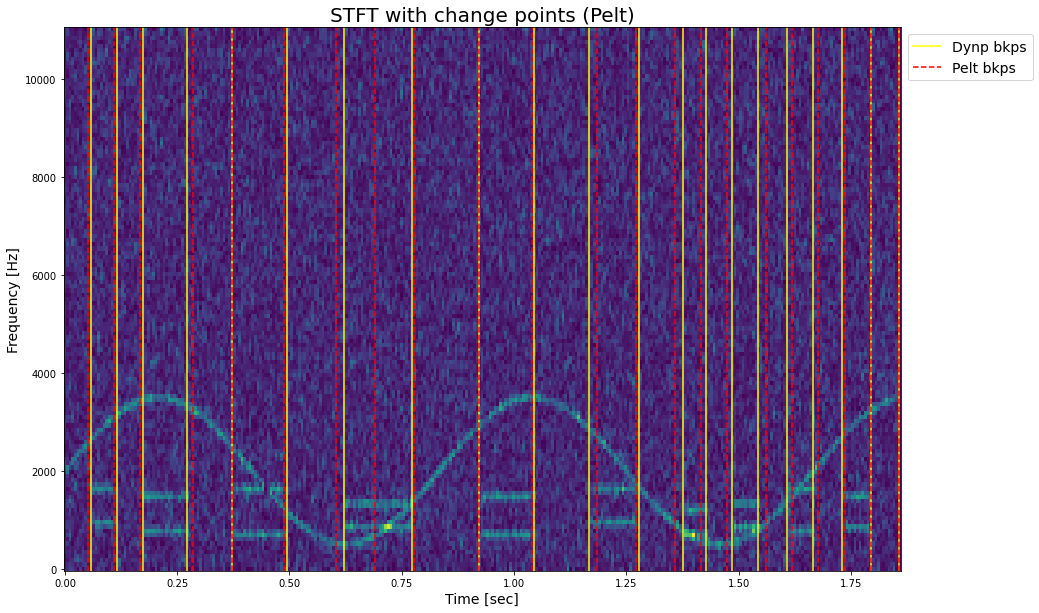

In [71]:
plt.figure(figsize=(15, 10))
plt.pcolormesh(times, frequencies, transform)
plt.ylabel("Frequency [Hz]", fontsize=14)
plt.xlabel("Time [sec]", fontsize=14)
for cp in true_change_points:
    plt.axvline(times[cp - 1], color="yellow", label="Dynp bkps")
for cp in pelt_bkps:
    plt.axvline(times[cp - 1], color="r", linestyle="--", label="Pelt bkps")
plt.title("STFT with change points (Pelt)", fontsize=20)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# localize the legend outside the plot
plt.legend(
    by_label.values(),
    by_label.keys(),
    fontsize=14,
    bbox_to_anchor=(1, 1),
    loc="upper left",
)
plt.show()

## Computation of the optimal penalty $\beta$ on the whole dataset

In [ ]:
def compute_total_cost(X, y, penalty):
    total_cost = 0
    for i in range(len(X)):
        signal = X[i]
        symbols = y[i]
        _, _, transform = stft(signal, FS)
        transform = np.abs(transform)
        change_points = rpt.Pelt().fit_predict(transform.T, pen=penalty)
        true_change_points = rpt.KernelCPD().fit_predict(
            transform.T, n_bkps=len(symbols) * 2
        )
        total_cost += compute_cost(signal, true_change_points, penalty) - compute_cost(
            signal, change_points, penalty
        )
    return total_cost / len(X)

In [ ]:
pen_list = np.linspace(0, 10, 20)
cost_list = []
for i, pen in enumerate(pen_list):
    print(f"iteration {i+1} / {len(pen_list)}", end="\r")
    cost_list.append(compute_total_cost(X_train, y_train, pen))

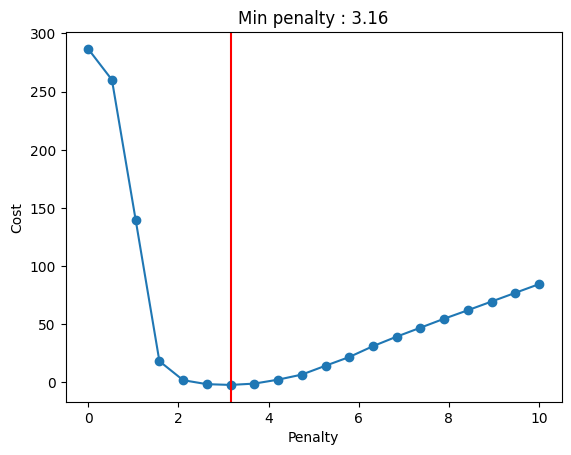

In [ ]:
plt.plot(pen_list, np.array(cost_list), marker="o")
min_pen = pen_list[np.argmin(np.array(cost_list))]
plt.axvline(min_pen, color="r")
plt.xlabel("Penalty")
plt.ylabel("Cost")
plt.title("Min penalty : " + str(round(min_pen, 2)))
plt.show()

## Classification of the signal patterns according to their symbols

We use the fact that the symbols are represented by a sum,
$$ y_t = \cos(2\pi f_1 t/ f_s) + \cos(2\pi f_2 t/ f_s)$$
where each couple $(f_1, f_2)$ (low frequency / high frequency) represents a symbol.

In [72]:
symbols = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "*", "#", "A", "B", "C", "D" ]

In [73]:
def extract_signals_and_labels(X, Y):
    label_list = []
    signals_list = []
    for x, y in zip(X, Y):
        _, _, transform = stft(x, FS)
        transform = np.abs(transform)
        brkp = rpt.KernelCPD().fit_predict(transform.T, n_bkps=len(y) * 2)
        for i in range(len(y)):
            signals_list.append(transform.T[brkp[2 * i] : brkp[2 * i + 1]])
            label_list.append(y[i])
    return signals_list, label_list

In [74]:
signals_list, label_list = extract_signals_and_labels(X_train, y_train)

For each signal corresponding to a fixed symbol, we extract all the frequency spectrums and store the frequency that corresponds to the largest peak

In [75]:
peak_frequency_by_symbol = dict()
for symbol in symbols:
    peak_frequency_by_symbol[symbol] = []
    all_sig = [s for i, s in enumerate(signals_list) if label_list[i] == symbol]
    for tf_sig in all_sig:
        for sig in tf_sig:
            peak_frequency_by_symbol[symbol].append(np.argmax(sig))
            sig[np.argmax(sig)] = 0

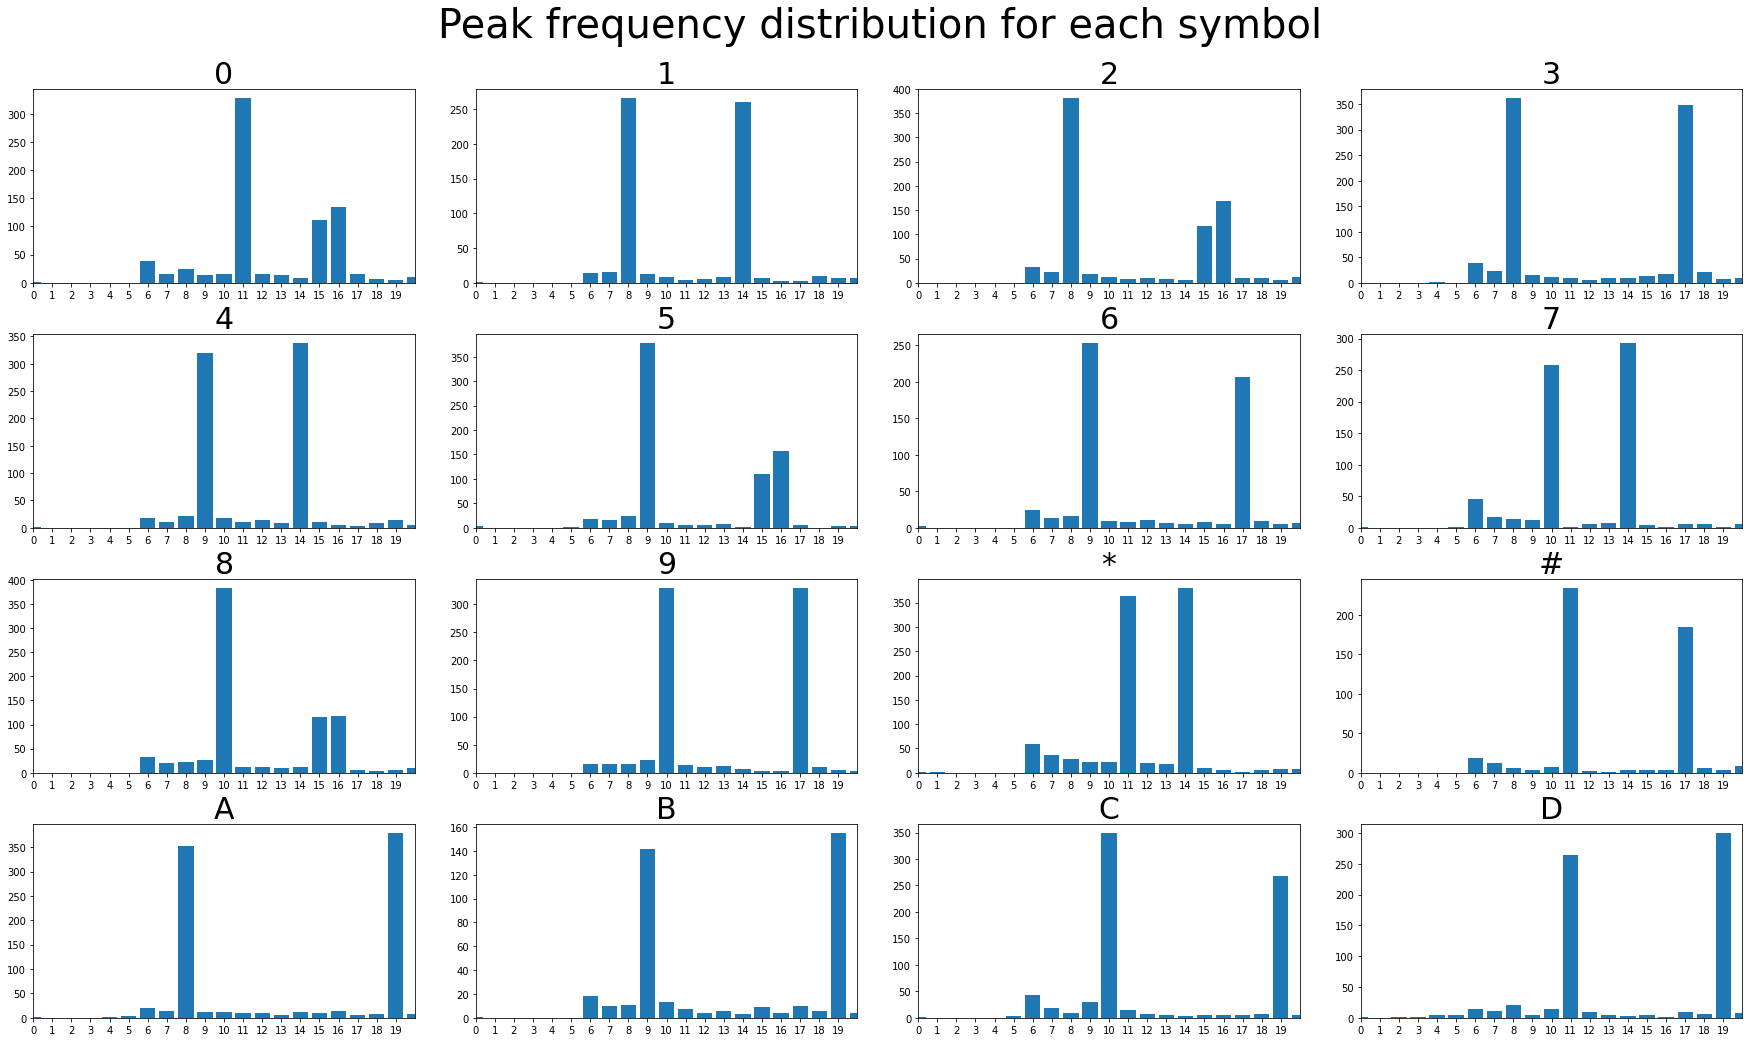

In [76]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.set_size_inches(25, 15)
fig.suptitle("Peak frequency distribution for each symbol", fontsize=40)
fig.tight_layout(pad=3.0)
axs = axs.ravel()
for i in range(16):
    vals_first_peak = peak_frequency_by_symbol[symbols[i]]
    values_first_peal, occurences_first_peak = np.unique(
        vals_first_peak, return_counts=True
    )

    axs[i].bar(values_first_peal, occurences_first_peak, label="First peak")

    axs[i].set_title(symbols[i], fontsize=30)
    axs[i].set_xlim([1, 20])
    # show all the ticks
    axs[i].set_xticks(np.arange(0, 20, 1))
# set a unique legend for the whole figure without duplicate entries
handles, labels = axs[0].get_legend_handles_labels()
plt.show()

### We then extract the two characteristic frequencies for each symbol and visualize them

In [77]:
characteristic_freq_by_symbol = dict()
for symbol in symbols:
    count = np.bincount(peak_frequency_by_symbol[symbol])
    argmax = count.argmax()
    count[argmax] = 0
    second_argmax = count.argmax()
    characteristic_freq_by_symbol[symbol] = sorted((argmax, second_argmax))

characteristic_freq_by_symbol = dict(
    sorted(characteristic_freq_by_symbol.items(), key=lambda item: item[1][0])
)

In [78]:
characteristic_freq_by_symbol

{'1': [8, 14],
 '2': [8, 16],
 '3': [8, 17],
 'A': [8, 19],
 '4': [9, 14],
 '5': [9, 16],
 '6': [9, 17],
 'B': [9, 19],
 '7': [10, 14],
 '8': [10, 16],
 '9': [10, 17],
 'C': [10, 19],
 '0': [11, 16],
 '*': [11, 14],
 '#': [11, 17],
 'D': [11, 19]}

In [79]:
all_freqs = list(characteristic_freq_by_symbol.values())
all_freqs = [f for freq in all_freqs for f in freq]
count_all_freqs = np.bincount(all_freqs)
count_all_freqs

array([0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 4, 0, 4, 4, 0, 4],
      dtype=int64)

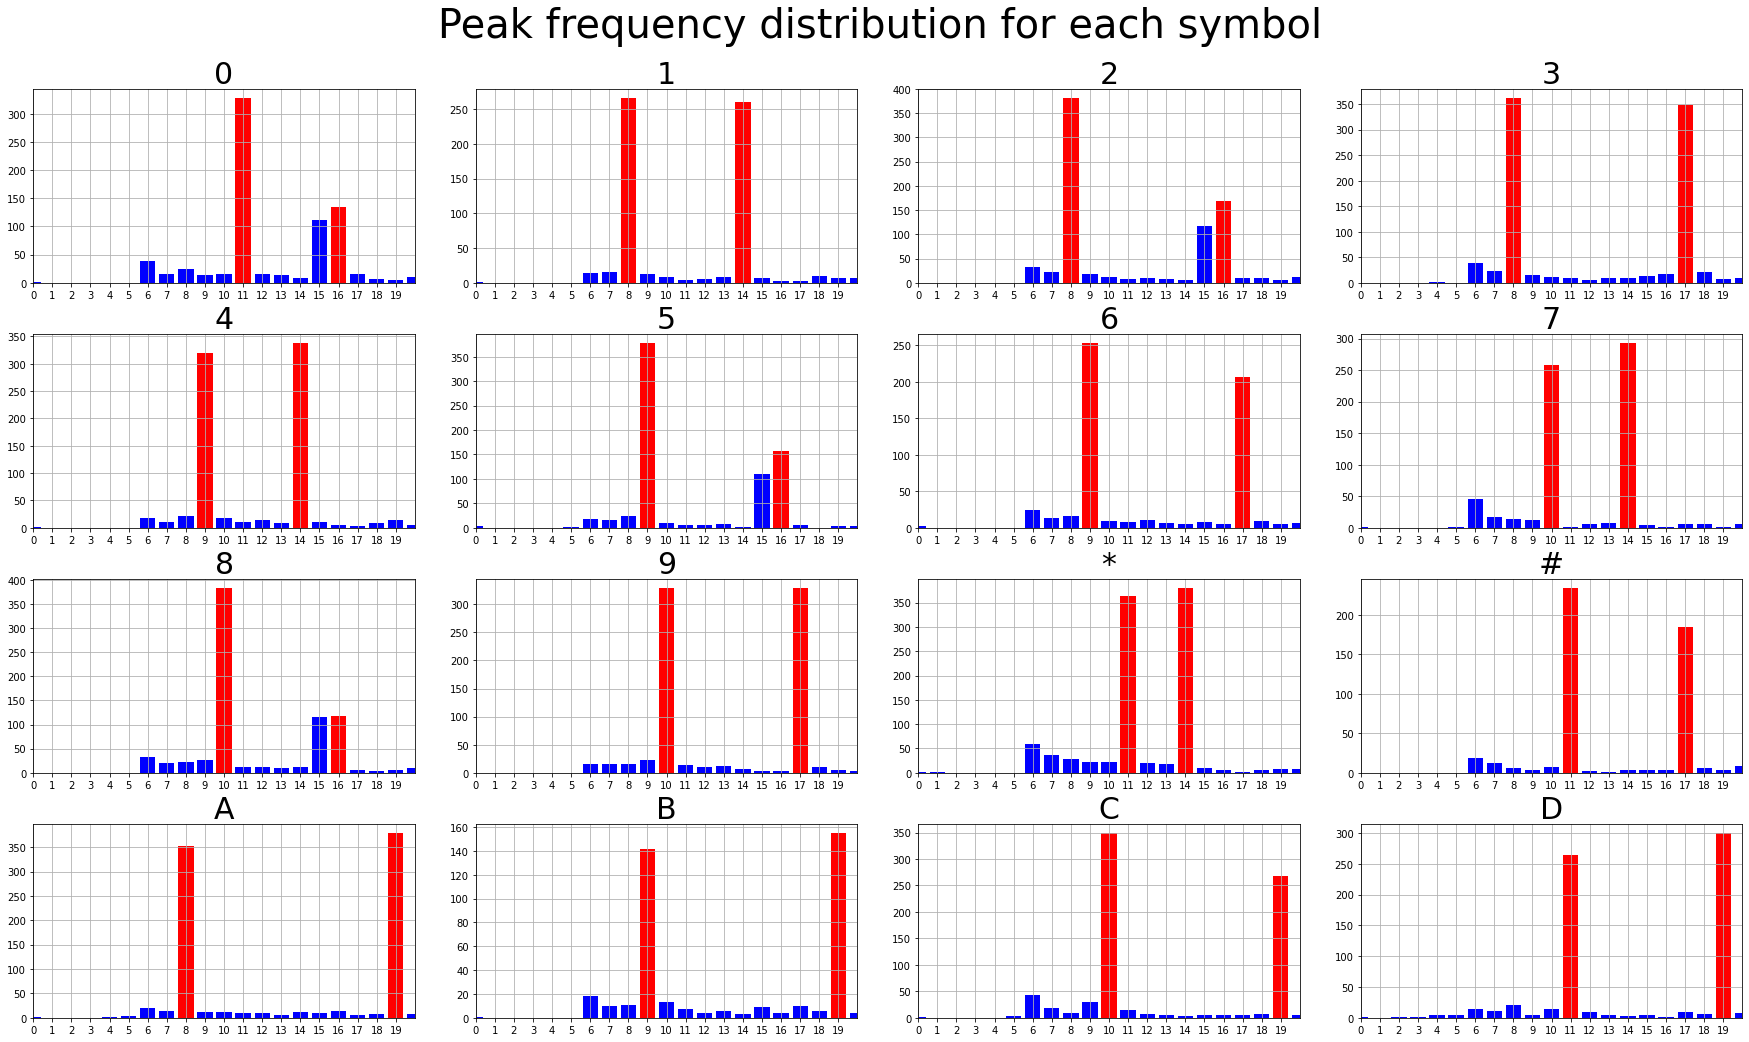

In [80]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.set_size_inches(25, 15)
fig.suptitle("Peak frequency distribution for each symbol", fontsize=40)
fig.tight_layout(pad=3.0)
axs = axs.ravel()
for i in range(16):
    vals_first_peak = peak_frequency_by_symbol[symbols[i]]
    values_first_peal, occurences_first_peak = np.unique(
        vals_first_peak, return_counts=True
    )

    color_list = [
        "r" if f in characteristic_freq_by_symbol[symbols[i]] else "b"
        for f in values_first_peal
    ]
    axs[i].bar(
        values_first_peal, occurences_first_peak, label="First peak", color=color_list
    )

    axs[i].set_title(symbols[i], fontsize=30)
    axs[i].set_xlim([1, 20])
    axs[i].set_xticks(np.arange(0, 20, 1))
    axs[i].grid()
# set a unique legend for the whole figure without duplicate entries
handles, labels = axs[0].get_legend_handles_labels()
plt.show()

# Question 2

### Using the optimal breakpoints with Dynp (We assume we know the optimal number of clusters)

In this section, we will try to cluster the signals using the characteristic frequencies we found in the previous section.

We will first assume that we know the number of clusters.

In [82]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()


def extract_patterns_dynpc(signal, K):
    _, _, transform_test = stft(signal, FS)
    transform_test = np.abs(transform_test)
    dynp_bkps = rpt.Dynp().fit_predict(transform_test.T, n_bkps=(K * 2))

    patterns = []

    for i in range(K):
        patterns.append(transform_test.T[dynp_bkps[2 * i] : dynp_bkps[2 * i + 1]])

    peak_frequencies = []
    for tf_sig in patterns:
        curr_list = []
        for sig in tf_sig:
            curr_list.append(np.argmax(sig))
        peak_frequencies.append(curr_list)

    # extrac the characteristic frequencies
    characteristic_freq = []
    for i in range(K):
        count = np.bincount(peak_frequencies[i])
        argmax = count.argmax()
        count[argmax] = 0
        second_argmax = count.argmax()
        characteristic_freq.append(sorted((argmax, second_argmax)))

    return peak_frequencies, characteristic_freq

## First test signal

### Visualization

In [84]:
signal = X_test[0]
output = stft(signal, FS)
frequencies, times, transform = output
transform = np.abs(transform)

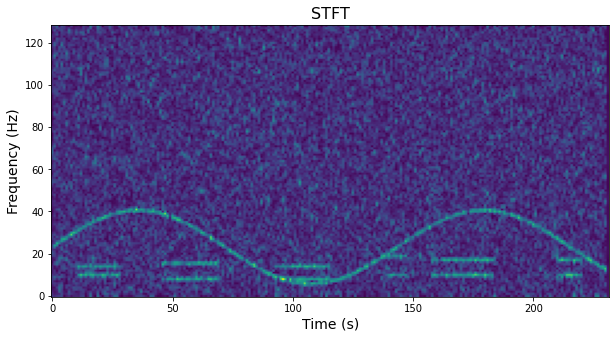

In [88]:
fig, axs = plt.subplots(figsize=(10, 5))
axs.imshow(transform, aspect="auto", origin="lower")
axs.set_title("STFT", fontsize=16)
axs.set_xlabel("Time (s)", fontsize=14)
axs.set_ylabel("Frequency (Hz)", fontsize=14)
plt.show()

We clearly distinguish $5$ sub-signals and $1$ indistinct signal. We decide to go with $K = 5$.

In [97]:
K = 5
number_of_breakpoints = K*2
dynp_bkps = rpt.Dynp().fit_predict(transform.T, n_bkps=number_of_breakpoints)

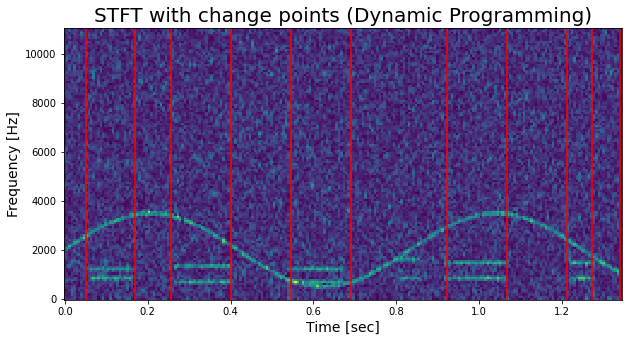

In [98]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, transform)
plt.ylabel("Frequency [Hz]", fontsize=14)
plt.xlabel("Time [sec]", fontsize=14)
for cp in dynp_bkps:
    plt.axvline(times[cp - 1], color="r")
plt.title("STFT with change points (Dynamic Programming)", fontsize=20)
plt.show()

In [99]:
peak_frequencies, characteristic_freq = extract_patterns_dynpc(X_test[0], 5)

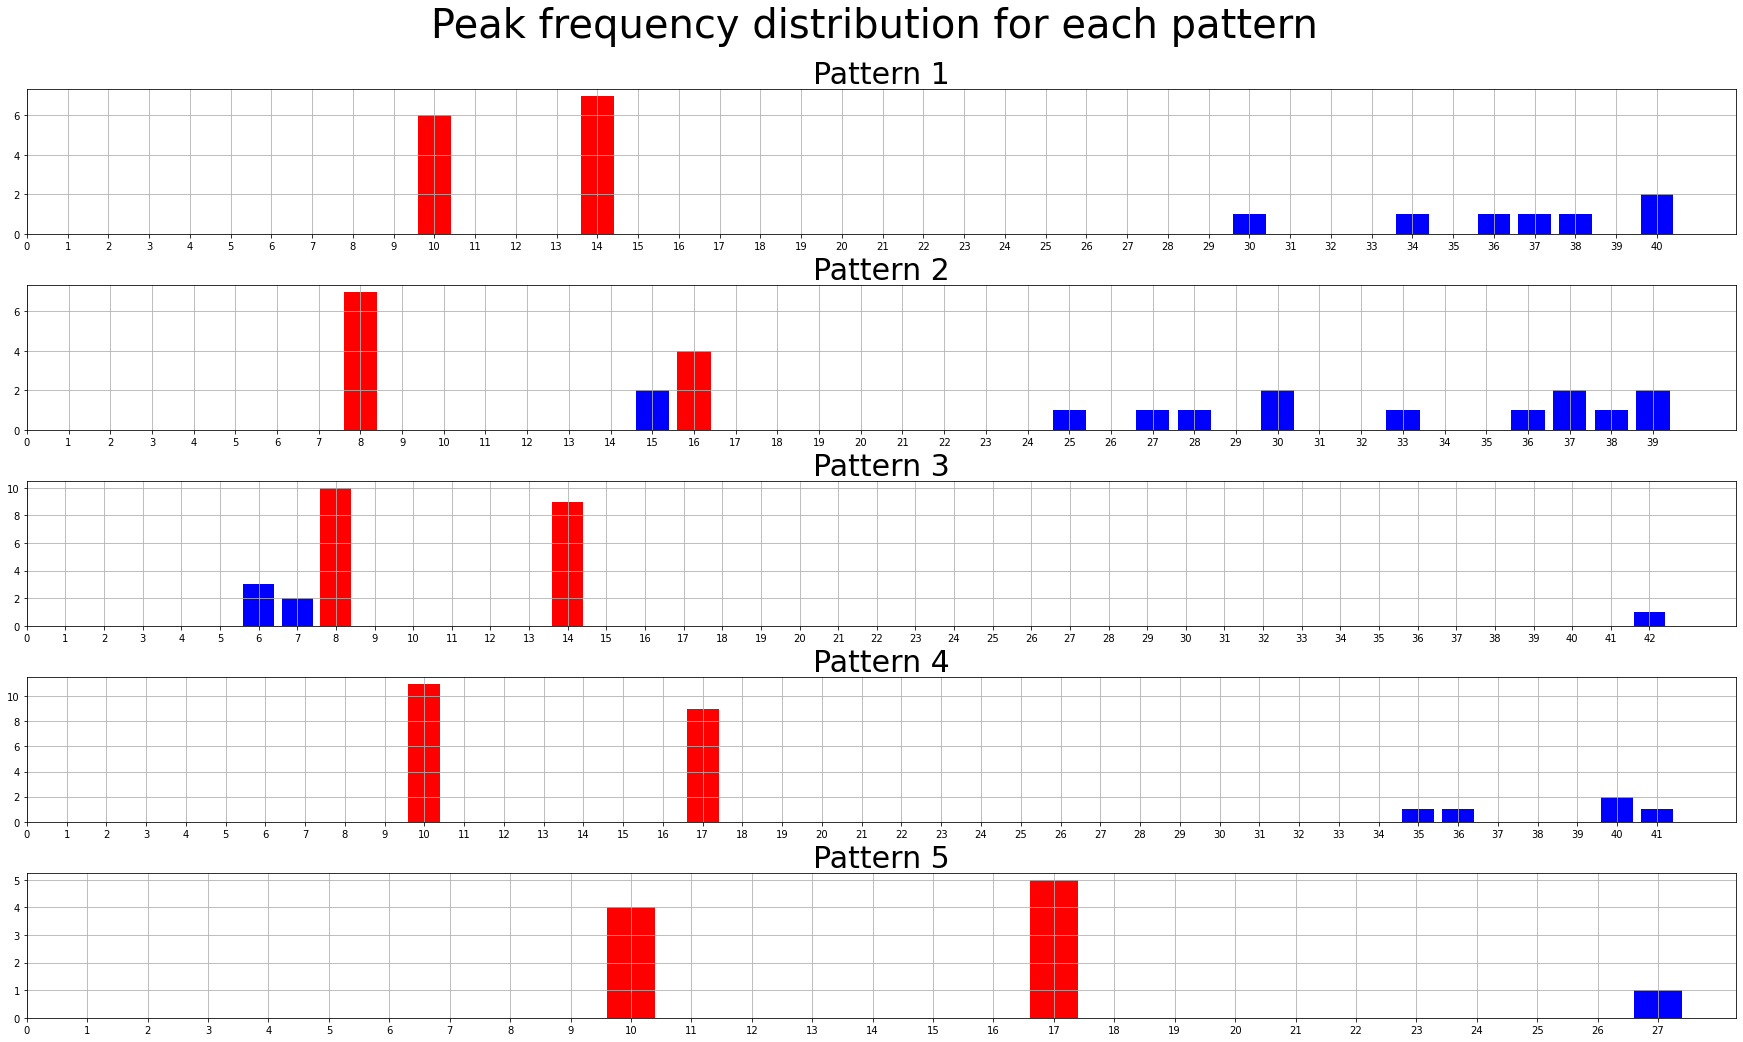

In [100]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15))
fig.set_size_inches(25, 15)
fig.suptitle("Peak frequency distribution for each pattern", fontsize=40)
fig.tight_layout(pad=3.0)
axs = axs.ravel()

for i in range(5):
    vals, occurences = np.unique(peak_frequencies[i], return_counts=True)
    color_list = ["r" if f in characteristic_freq[i] else "b" for f in vals]
    axs[i].bar(vals, occurences, label="First peak", color=color_list)
    axs[i].set_title("Pattern " + str(i + 1), fontsize=30)
    axs[i].set_xticks(np.arange(0, max(vals) + 1, 1))
    axs[i].grid()
plt.show()

In [101]:
symbol_by_characteristic_freq = dict()
for symbol, characteristic_frequency in characteristic_freq_by_symbol.items():
    symbol_by_characteristic_freq[tuple(characteristic_frequency)] = symbol

In [102]:
print("***First test signal***")
print("The extracted characteristic frequencies are :", characteristic_freq)
print(
    "The corresponding symbols are :",
    [symbol_by_characteristic_freq[tuple(f)] for f in characteristic_freq],
)

***First test signal***
The extracted characteristic frequencies are : [[10, 14], [8, 16], [8, 14], [10, 17], [10, 17]]
The corresponding symbols are : ['7', '2', '1', '9', '9']


### Second test signal

In [104]:
signal = X_test[1]
output = stft(signal, FS)
frequencies, times, transform = output
transform = np.abs(transform)

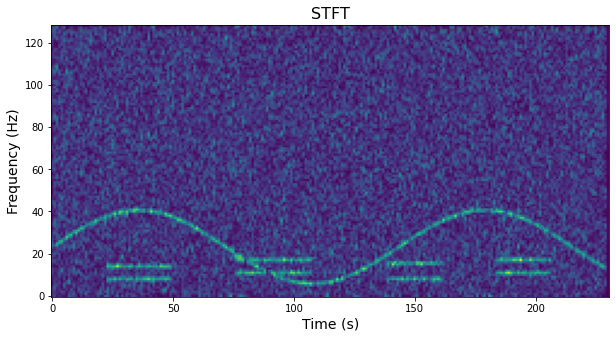

In [105]:
fig, axs = plt.subplots(figsize=(10, 5))
axs.imshow(transform, aspect="auto", origin="lower")
axs.set_title("STFT", fontsize=16)
axs.set_xlabel("Time (s)", fontsize=14)
axs.set_ylabel("Frequency (Hz)", fontsize=14)
plt.show()

We distinguish 4 sub-signals

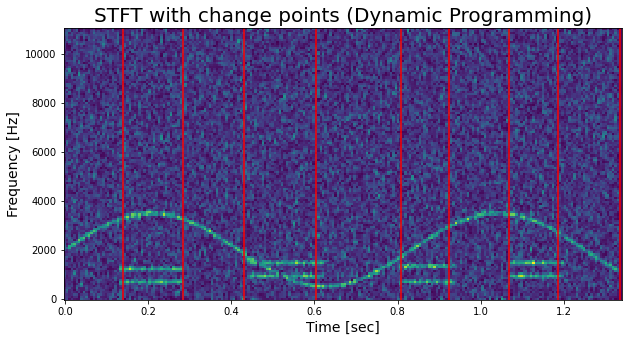

In [106]:
K = 4
number_of_breakpoints = K*2
dynp_bkps = rpt.Dynp().fit_predict(transform.T, n_bkps=number_of_breakpoints)

plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, transform)
plt.ylabel("Frequency [Hz]", fontsize=14)
plt.xlabel("Time [sec]", fontsize=14)
for cp in dynp_bkps:
    plt.axvline(times[cp - 1], color="r")
plt.title("STFT with change points (Dynamic Programming)", fontsize=20)
plt.show()

In [107]:
peak_frequencies, characteristic_freq = extract_patterns_dynpc(X_test[1], 4)

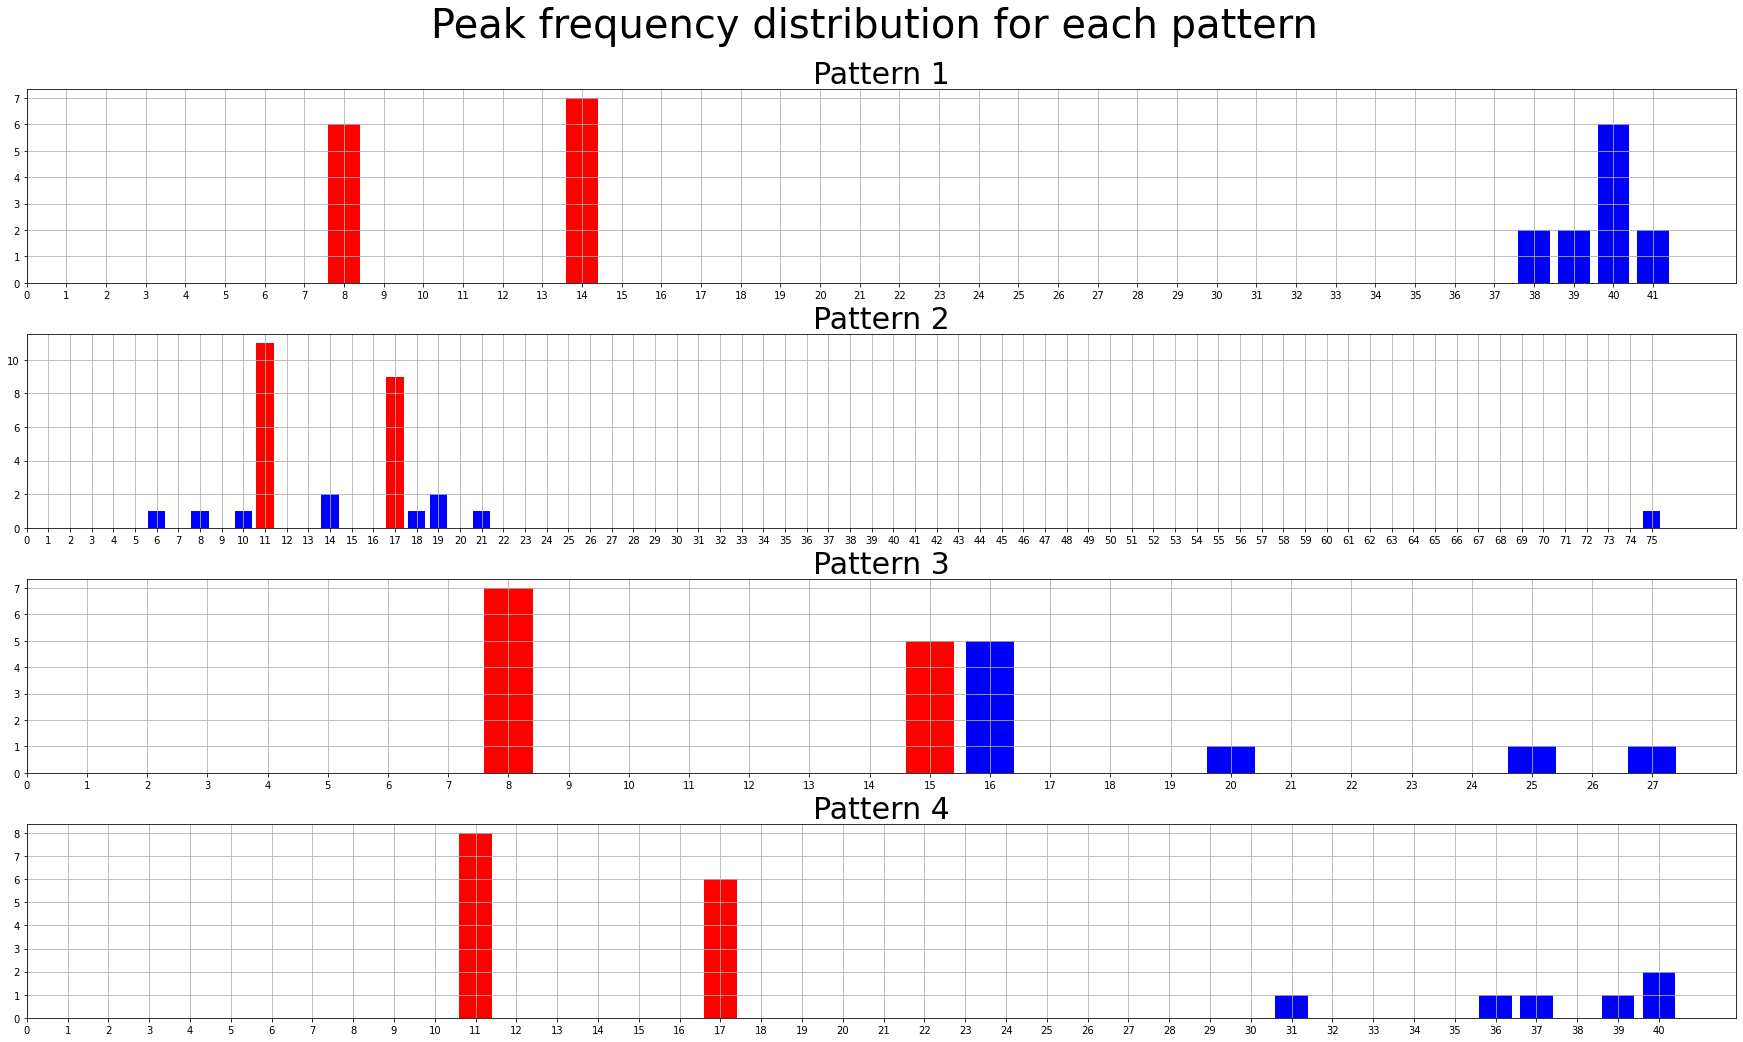

In [108]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.set_size_inches(25, 15)
fig.suptitle("Peak frequency distribution for each pattern", fontsize=40)
fig.tight_layout(pad=3.0)
axs = axs.ravel()

for i in range(4):
    vals, occurences = np.unique(peak_frequencies[i], return_counts=True)
    color_list = ["r" if f in characteristic_freq[i] else "b" for f in vals]
    axs[i].bar(vals, occurences, label="First peak", color=color_list)
    axs[i].set_title("Pattern " + str(i + 1), fontsize=30)
    axs[i].set_xticks(np.arange(0, max(vals) + 1, 1))
    axs[i].grid()
plt.show()

In [109]:
print("***Second test signal***")
print("The extracted characteristic frequencies are :", characteristic_freq)
print()
print(
    "We see that we get [8,15], but 15 was not recognized as a characteristic frequency in the training set"
)
print(
    "However we see that the peak 15 is always present when the peak 16 is present, so we can use this information to recognize the symbol"
)
print()
corrected_characteristic_freq = characteristic_freq.copy()
corrected_characteristic_freq[2] = [8, 16]
print("The corrected characteristic frequencies are :", corrected_characteristic_freq)
print(
    "The corresponding symbols are :",
    [symbol_by_characteristic_freq[tuple(f)] for f in corrected_characteristic_freq],
)

***Second test signal***
The extracted characteristic frequencies are : [[8, 14], [11, 17], [8, 15], [11, 17]]

We see that we get [8,15], but 15 was not recognized as a characteristic frequency in the training set
However we see that the peak 15 is always present when the peak 16 is present, so we can use this information to recognize the symbol

The corrected characteristic frequencies are : [[8, 14], [11, 17], [8, 16], [11, 17]]
The corresponding symbols are : ['1', '#', '2', '#']


## Now let's see, out of curiosity, if our computed optimal penalty gives a decent breakpoint detection.

### We recall that $\beta_{opt} = 3.16$

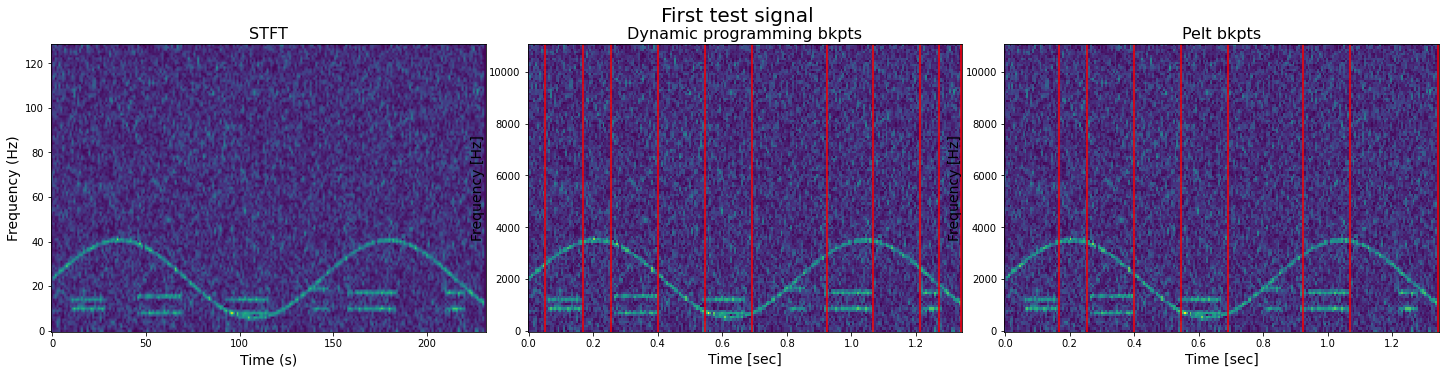

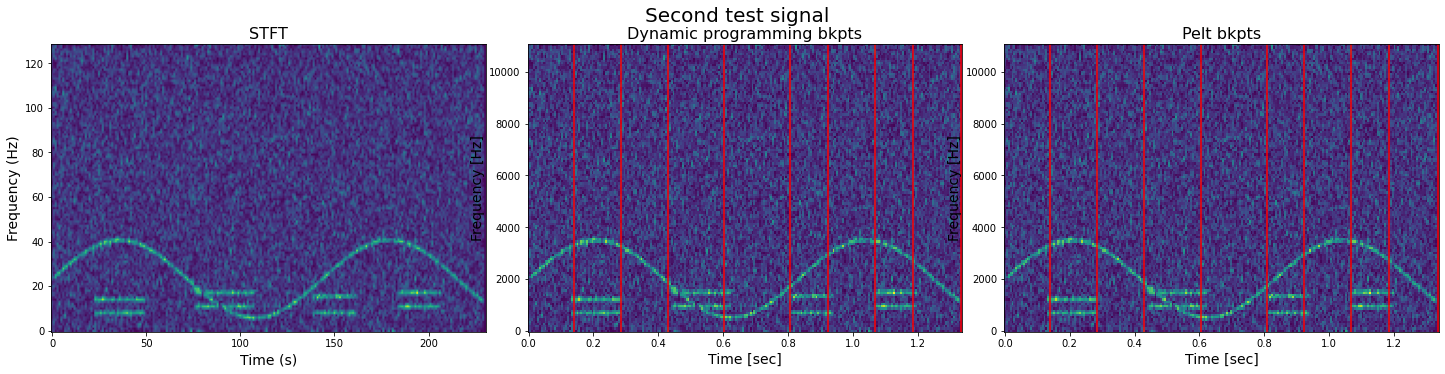

In [126]:
# first signal
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("First test signal", fontsize=20)
fig.tight_layout()

signal = X_test[0]
output = stft(signal, FS)
frequencies, times, transform = output
transform = np.abs(transform)

ax[0].imshow(transform, aspect="auto", origin="lower")
ax[0].set_title("STFT", fontsize=16)
ax[0].set_xlabel("Time (s)", fontsize=14)
ax[0].set_ylabel("Frequency (Hz)", fontsize=14)

K = 5
number_of_breakpoints = K*2
dynp_bkps = rpt.Dynp().fit_predict(transform.T, n_bkps=number_of_breakpoints)

ax[1].pcolormesh(times, frequencies, transform)
ax[1].set_ylabel("Frequency [Hz]", fontsize=14)
ax[1].set_xlabel("Time [sec]", fontsize=14)
for cp in dynp_bkps:
    ax[1].axvline(times[cp - 1], color="r")
ax[1].set_title("Dynamic programming bkpts", fontsize=16)

pelt_bkps = rpt.Pelt().fit_predict(transform.T, pen=3.16)

ax[2].pcolormesh(times, frequencies, transform)
ax[2].set_ylabel("Frequency [Hz]", fontsize=14)
ax[2].set_xlabel("Time [sec]", fontsize=14)
for cp in pelt_bkps:
    ax[2].axvline(times[cp - 1], color="r")
ax[2].set_title("Pelt bkpts", fontsize=16)

plt.show()

# second signal
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Second test signal", fontsize=20)
fig.tight_layout()

signal = X_test[1]
output = stft(signal, FS)
frequencies, times, transform = output
transform = np.abs(transform)

ax[0].imshow(transform, aspect="auto", origin="lower")
ax[0].set_title("STFT", fontsize=16)
ax[0].set_xlabel("Time (s)", fontsize=14)
ax[0].set_ylabel("Frequency (Hz)", fontsize=14)

K = 4
number_of_breakpoints = K*2
dynp_bkps = rpt.Dynp().fit_predict(transform.T, n_bkps=number_of_breakpoints)

ax[1].pcolormesh(times, frequencies, transform)
ax[1].set_ylabel("Frequency [Hz]", fontsize=14)
ax[1].set_xlabel("Time [sec]", fontsize=14)
for cp in dynp_bkps:
    ax[1].axvline(times[cp - 1], color="r")
ax[1].set_title("Dynamic programming bkpts", fontsize=16)

pelt_bkps = rpt.Pelt().fit_predict(transform.T, pen=3.16)

ax[2].pcolormesh(times, frequencies, transform)
ax[2].set_ylabel("Frequency [Hz]", fontsize=14)
ax[2].set_xlabel("Time [sec]", fontsize=14)
for cp in pelt_bkps:
    ax[2].axvline(times[cp - 1], color="r")
ax[2].set_title("Pelt bkpts", fontsize=16)

plt.show()


Although not perfect for the first signal, we see that the computed optimal penalty $\beta_{opt}$ still performs decently.

We remember that the optimal penalty is computed as an average on the whole training dataset, so it isn't very surprsing to see variable performance depending on the test sample.

# Question 3

In [3]:
M = 9


def partial_g(
    lambd: Union[np.ndarray, float], R: float, lambda_max: float
) -> Union[np.ndarray, float]:
    a = lambda_max / (M + 1 - R)
    return (
        (lambd < 0)
        * (lambd >= -R * a)
        * 1
        / 2
        * (1 + np.cos(2 * np.pi * (1 / 2 + lambd / a / R)))
    )


def g(
    lambd: Union[np.ndarray, float], m: int, R: float, lambda_max: float
) -> Union[np.ndarray, float]:
    a = lambda_max / (M + 1 - R)
    return partial_g(lambd - a * m, R, lambda_max)

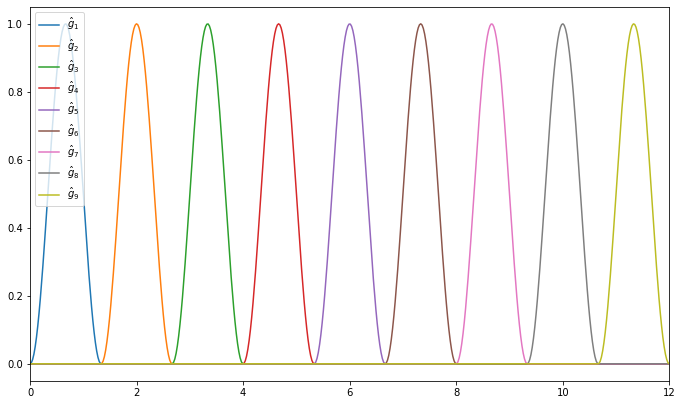

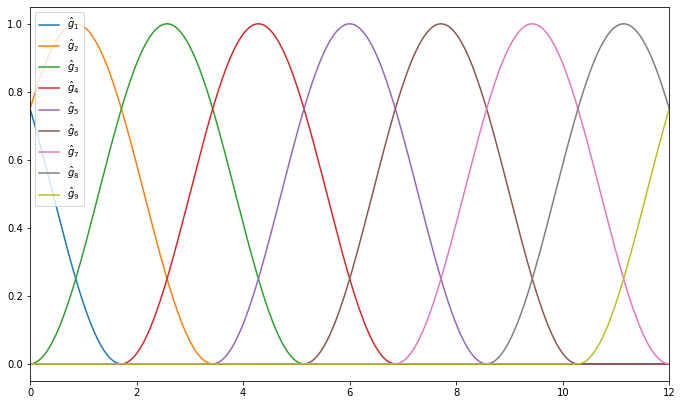

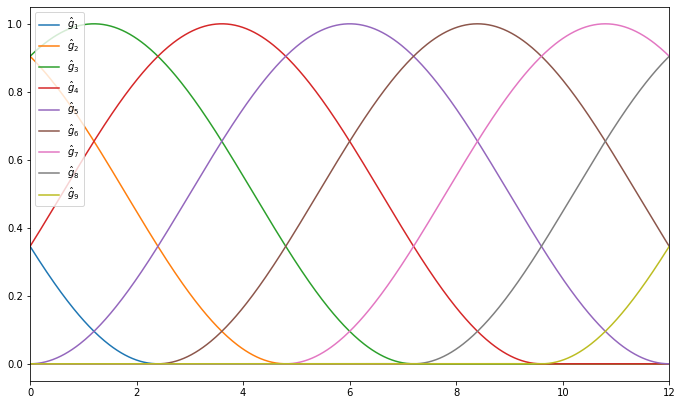

In [4]:
lambda_max = 12
for R in [1, 3, 5]:
    fig, ax = fig_ax()
    for m in range(1, M + 1):
        lambd = np.linspace(0, lambda_max, 500)
        ax.plot(lambd, g(lambd, m, R, lambda_max), label=rf"$\hat{{g}}_{m}$")
    plt.legend(loc="upper left")
    plt.savefig(f"figures/g_{R}.png")
    plt.show()

# Question 4

In [5]:
dataset = load_molene_meteo_dataset()

In [6]:
data_df: pd.DataFrame = dataset[0]
stations_df: pd.DataFrame = dataset[1]

#  Remove all stations with missing values in the temperature
data_df = data_df.assign(temp=lambda x: x.t - 273.15)
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")

missing_df = temperature_df.isna()
missing_df = missing_df.sum(axis=0)
missing_df = missing_df[missing_df > 0]

stations_to_remove = missing_df.index.tolist()
stations_df = stations_df.loc[~stations_df.loc[:, "Nom"].isin(stations_to_remove)]
data_df = data_df.loc[~data_df.loc[:, "station_name"].isin(stations_to_remove)]

print("Stations with missing values :", stations_to_remove)

temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")

# Remove rows with missing values
temperature_df = temperature_df.dropna(axis=0)

temperature_df.head()

Stations with missing values : ['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET', 'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA', 'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN', 'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON']


station_name         AURAY  BELLE ILE-LE TALUT  BIGNAN  DINARD  GUERANDE  \
date                                                                       
2014-01-01 00:00:00   10.3                11.3     7.1     6.8      10.4   
2014-01-01 01:00:00   10.4                10.3     7.6     6.5      10.6   
2014-01-01 02:00:00   10.0                11.2     7.7     6.5      10.2   
2014-01-01 03:00:00   10.4                11.4     7.9     7.1      10.6   
2014-01-01 04:00:00   10.8                11.4     8.8     7.6      10.6   

station_name         GUISCRIFF SA  ILE DE GROIX  ILE-DE-BREHAT  KERPERT  \
date                                                                      
2014-01-01 00:00:00           8.3           9.0            7.0      5.9   
2014-01-01 01:00:00           7.8          10.0            7.0      5.9   
2014-01-01 02:00:00           8.4           9.5            7.8      6.4   
2014-01-01 03:00:00           8.4          10.4            8.3      6.7   
2014-01-01 04:00:00           8.9          10.8            8.9      6.9   

station_name         LORIENT-LANN BIHOUE  ...  SAINT-CAST-LE-G  \
date                                      ...                    
2014-01-01 00:00:00                  9.0  ...              6.1   
2014-01-01 01:00:00                 10.0  ...              6.3   
2014-01-01 02:00:00                  8.9  ...              6.4   
2014-01-01 03:00:00                 10.1  ...              7.0   
2014-01-01 04:00:00                 10.4  ...              7.7   

station_name         SAINT-JOACHIM_SAE  SARZEAU SA  SIBIRIL S A  SPEZET  \
date                                                                      
2014-01-01 00:00:00                9.3         9.8          7.4     8.3   
2014-01-01 01:00:00                9.3         9.9          8.2     8.6   
2014-01-01 02:00:00                9.5         9.2          8.5     8.6   
2014-01-01 03:00:00                9.0        10.1          8.5     8.9   
2014-01-01 04:00:00                9.9        10.5          9.1     9.4   

station_name         ST BRIEUC  ST-SEGAL S A  THEIX  TREGUNC  VANNES-SENE  
date                                                                       
2014-01-01 00:00:00        7.5           9.0    9.3     10.8          9.7  
2014-01-01 01:00:00        7.0           9.5    9.1     10.9          9.9  
2014-01-01 02:00:00        7.5           9.4    9.4     10.6          9.6  
2014-01-01 03:00:00        7.2           9.9    8.9     10.8          9.8  
2014-01-01 04:00:00        7.6          10.0    9.6     11.0         10.2  

[5 rows x 37 columns]

In [7]:
CRS = "EPSG:4326"
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df.Longitude, stations_df.Latitude),
).set_crs(CRS)

stations_gdf.head()

Numéro            Nom   Latitude  Longitude  X (Lambert II étendu)  \
0  22016001  ILE-DE-BREHAT  48.855167  -3.004500                 208083   
1  22092001        KERPERT  48.404000  -3.147667                 194096   
3  22135001       LOUARGAT  48.551667  -3.376833                 178359   
4  22147006     MERDRIGNAC  48.182667  -2.410833                 247067   
5  22168001    PLOUMANAC'H  48.825833  -3.473167                 173516   

   Y (Lambert II étendu)  Altitude                   geometry  
0                2441852        25  POINT (-3.00450 48.85517)  
1                2392507       281  POINT (-3.14767 48.40400)  
3                2410097       148  POINT (-3.37683 48.55167)  
4                2364385       131  POINT (-2.41083 48.18267)  
5                2441036        55  POINT (-3.47317 48.82583)

In [8]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)

sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = 0.83
adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)
G = graphs.Graph(adjacency_matrix_gaussian)
print(
    f"The graph is {'not ' if not is_connected(G) else ''}connected, with {G.N} nodes, {G.Ne} edges"
)
print("The average degree is", np.mean(G.d))

The graph is connected, with 37 nodes, 75 edges
The average degree is 4.054054054054054


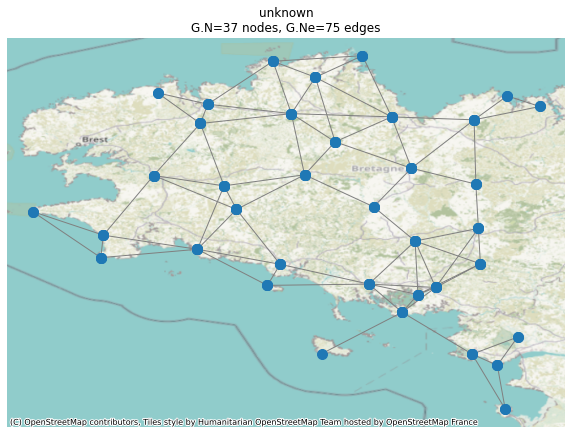

In [9]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot(ax=ax)

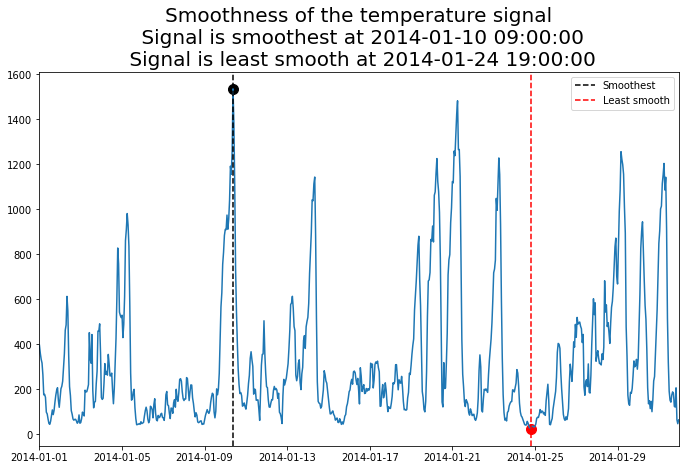

In [10]:
smoothness = []
laplacian_matrix = G.L.todense()
for time in temperature_df.index:
    signal = temperature_df.loc[time].to_numpy()
    s = signal.T.dot(laplacian_matrix).dot(signal)[0, 0]
    smoothness.append(s)
fig, ax = fig_ax()
ax.plot(temperature_df.index, smoothness)

smooth_index = temperature_df.index[np.argmax(smoothness)]
not_smooth_index = temperature_df.index[np.argmin(smoothness)]

ax.axvline(smooth_index, color="black", linestyle="--", label="Smoothest")
ax.scatter(smooth_index, smoothness[np.argmax(smoothness)], color="black", s=100)
ax.axvline(not_smooth_index, color="r", linestyle="--", label="Least smooth")
ax.scatter(not_smooth_index, smoothness[np.argmin(smoothness)], color="r", s=100)
ax.set_title("Smoothness of the temperature signal\n Signal is smoothest at " + str(smooth_index) + "\n Signal is least smooth at " + str(not_smooth_index), fontsize=20)
ax.legend()
plt.show()

# Question 5

In [11]:
def get_features(signal: np.ndarray, laplacian_matrix: np.ndarray) -> np.ndarray:
    n = len(signal)
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    dft = eigenvectors.T.dot(signal).T.A1

    features = np.zeros((n, M))
    for v in range(n):
        for m in range(1, M + 1):
            eigenvector = np.zeros((n))
            eigenvector[:] = eigenvectors[v, :]
            features[v, m - 1] = np.sum(
                g(eigenvalues, m, 3, np.max(eigenvalues)) * dft * eigenvector
            )**2

    return features

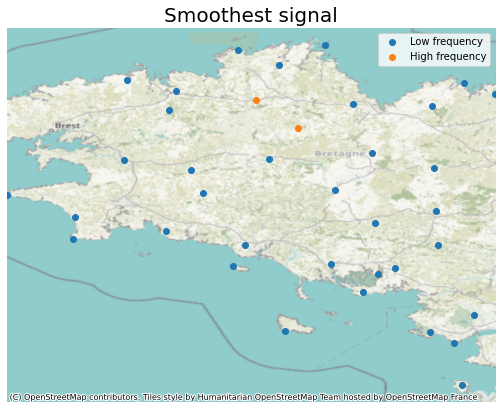

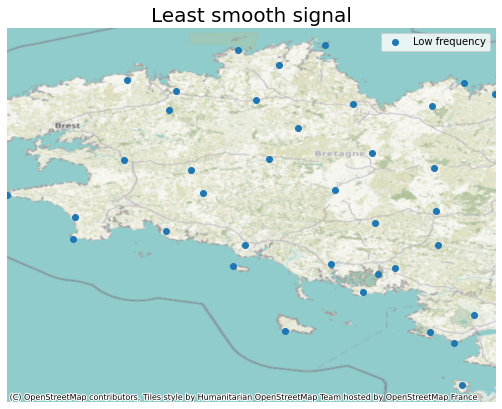

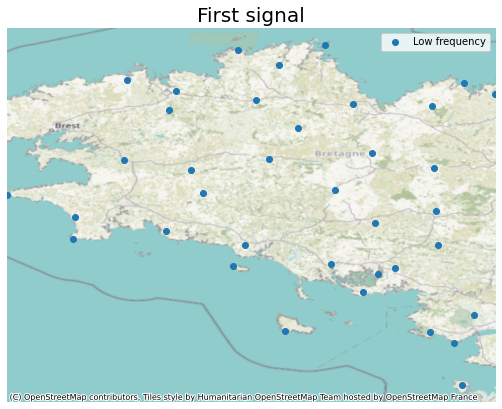

In [12]:
smooth_signal = temperature_df.loc[smooth_index].to_numpy()
not_smooth_signal = temperature_df.loc[not_smooth_index].to_numpy()
first_signal = temperature_df.iloc[0].to_numpy()


for signal, name in zip(
    [smooth_signal, not_smooth_signal, first_signal],
    ["smooth_signal", "not_smooth_signal", "first_signal"],
):
    features = get_features(signal, laplacian_matrix)
    class_energies = np.array(
        [
            np.sum(features[:, 0:3], axis=1),
            np.sum(features[:, 3:6], axis=1),
            np.sum(features[:, 6:9], axis=1),
        ]
    )

    title_by_name = {"smooth_signal": "Smoothest signal", "not_smooth_signal": "Least smooth signal", "first_signal": "First signal"}
    classification = np.argmax(class_energies, axis=0)
    fig, ax = fig_ax()
    ax.set_title(title_by_name[name], fontsize=20)

    if np.count_nonzero(classification == 0) > 0:
        stations_gdf[classification == 0].geometry.plot(ax=ax, label="Low frequency")
    if np.count_nonzero(classification == 1) > 0:
        stations_gdf[classification == 1].geometry.plot(ax=ax, label="Medium frequency")
    if np.count_nonzero(classification == 2) > 0:
        stations_gdf[classification == 2].geometry.plot(ax=ax, label="High frequency")
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    plt.legend()
    plt.savefig(f"figures/{name}.png")
    plt.show()

# Question 6

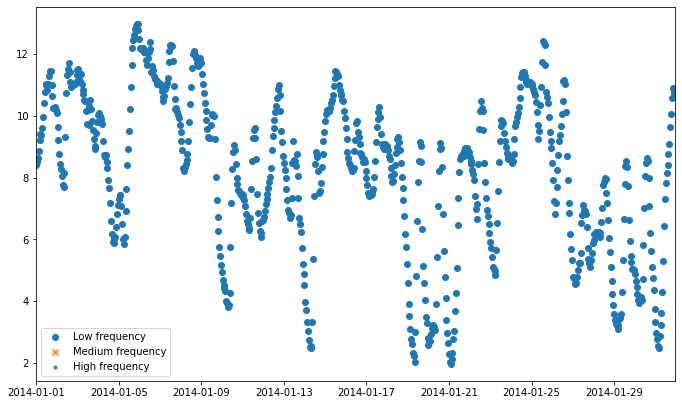

In [13]:
average_temperatures = []
majority_classes = []

for k, t in enumerate(temperature_df.index):
    print(f"{k} / {len(temperature_df.index)}", end="\r")
    signal = temperature_df.loc[t].to_numpy()
    features = get_features(signal, laplacian_matrix)
    class_energies = np.array(
        [
            np.sum(features[:, 0:3], axis=1),
            np.sum(features[:, 3:6], axis=1),
            np.sum(features[:, 6:9], axis=1),
        ]
    )

    classification = np.argmax(class_energies, axis=0)
    majority_classes.append(np.argmax(np.bincount(classification)))
    average_temperatures.append(np.mean(signal))

average_temperatures = np.array(average_temperatures)
majority_classes = np.array(majority_classes)

fig, ax = fig_ax()
ax.scatter(
    temperature_df.index[majority_classes == 0],
    average_temperatures[majority_classes == 0],
    marker="o",
    label="Low frequency",
)
ax.scatter(
    temperature_df.index[majority_classes == 1],
    average_temperatures[majority_classes == 1],
    marker="x",
    label="Medium frequency",
)
ax.scatter(
    temperature_df.index[majority_classes == 2],
    average_temperatures[majority_classes == 2],
    marker=".",
    label="High frequency",
)
ax.legend()
plt.savefig("figures/average_temperature.png")
plt.show()

# Question 7

First, we compute the Laplacian matricies of $G$ and $G'$

In [14]:
n_time_steps = len(temperature_df.index)
G_prime = get_line_graph(n_nodes=n_time_steps)
G_prime_lap = G_prime.L.todense()

G_lap = G.L.todense()


We could want to compute $H$ as the cartesian product of $G$ and $G'$ and then compute all their eigenvalues/eigenvectors.

However, this is not feasible since the total number of elements in the Laplacian of $H$ would be too high and the computation of the eigenvectors would be too expensive.


In [15]:
number = (G.N * G_prime.N)**2
print(f"{number:,} elements")

757,790,784 elements


We nevertheless have a very important property of the eigenvalues/eigenvectors of the cartesian product of graphs (https://math.stackexchange.com/questions/1799091/spectral-graph-theory-cartesian-product-of-laplace-matrix).

We see that the eigenvalues of the Laplacian of $H$ are the sum of the eigenvalues of the Laplacians of $G$ and $G'$, and the corresponding eigenvectors of $H$ are the Kronecker products of the respective eigenvectors of $G$ and $G'$.

Since storing all the eigenvectors is too expensive memory-wise, we simply dynamically compute them and compute the corresponding dfts.

In [21]:
signal = temperature_df.to_numpy().T
print(signal.shape)
n = len(signal.flatten())
dft = np.zeros((signal.shape[0], signal.shape[1]))

(37, 744)


In [22]:
eigvals_G, eigvecs_G = eigh(G_lap)
eigvals_G_prime, eigvecs_G_prime = eigh(G_prime_lap)

eigvals_H = list()

for i in range(G.N):
    for j in range(G_prime.N):
        curr_iter = i * G_prime.N + j
        print(f"{curr_iter} / {G.N * G_prime.N}", end="\r")
        curr_eigvec = np.kron(eigvecs_G[:, i], eigvecs_G_prime[:, j])
        dft[i, j] = curr_eigvec.T.dot(signal.flatten()).T
        eigvals_H.append(eigvals_G[i] + eigvals_G_prime[j])

eigvals_H = np.array(eigvals_H)

We now can compute the feature matrix

In [35]:
dft = dft.flatten()
features = np.zeros((n, M))
for v in range(n):
    for m in range(1, M + 1):
        curr_iter = v * M + m
        print(f"{curr_iter} / {n * M}", end="\r")
        i, j = v // G_prime.N, v % G_prime.N
        eigenvector = np.kron(eigvecs_G[:, i], eigvecs_G_prime[:, j])
        features[v, m - 1] = np.sum(
            g(eigvals_H, m, 3, np.max(eigvals_H)) * dft * eigenvector
        )**2

We compute the majority classes node-wise, and then timestamp-averaged-wise

In [39]:
majority_classes = list()
for v in range(n):
    print(f"{v} / {n}", end="\r")
    vals = np.sum(features[v, 0:3]), np.sum(features[v, 3:6]), np.sum(features[v, 6:9])
    majority_classes.append(np.argmax(vals))

In [42]:
majority_classes = np.array(majority_classes)

In [51]:
majority_classes = majority_classes.reshape((G.N, G_prime.N))
averaged_majority_classes = np.zeros(G_prime.N)
for i in range(G_prime.N):
    count = np.bincount(majority_classes[:, i])
    averaged_majority_classes[i] = np.argmax(count)

Visualization

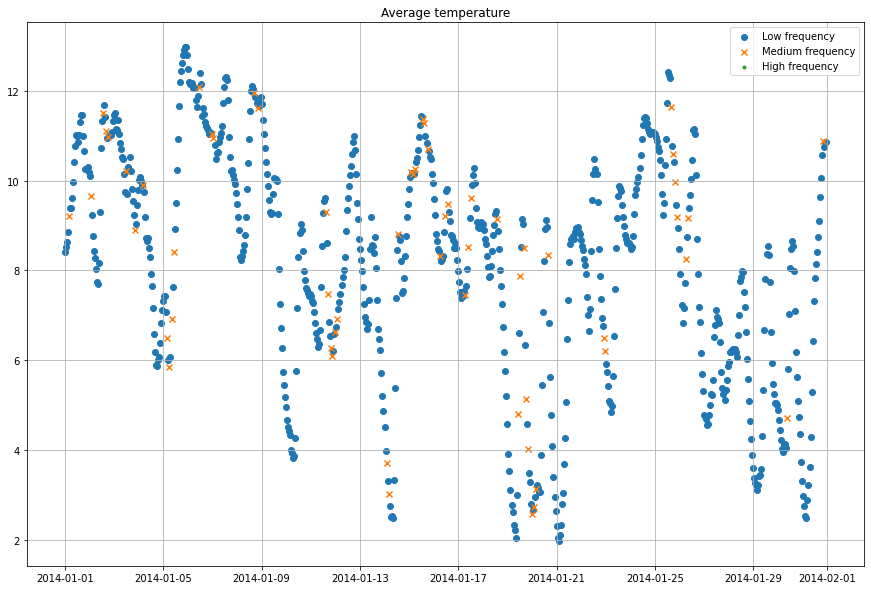

In [58]:
plt.figure(figsize=(15, 10))

plt.scatter(
    temperature_df.index[averaged_majority_classes == 0],
    average_temperatures[averaged_majority_classes == 0],
    marker="o",
    label="Low frequency",
)
plt.scatter(
    temperature_df.index[averaged_majority_classes == 1],
    average_temperatures[averaged_majority_classes == 1],
    marker="x",
    label="Medium frequency",
)
plt.scatter(
    temperature_df.index[averaged_majority_classes == 2],
    average_temperatures[averaged_majority_classes == 2],
    marker=".",
    label="High frequency",
)

plt.legend()
plt.grid()
plt.savefig("figures/average_temperature_Q7.png")
plt.title("Average temperature")

plt.show()